4.1 Use the function thermalConductivity to investigate the temperature dependence 
of thermal conductivity. At what temperature is the thermal conductivity of we 
soil independent of water content? Explain why the temperature dependence  f
conductivity disappears at this temperature

In [8]:
#from math import exp
import matplotlib.pyplot as plt
import numpy as np
from PSP_heat import *
from PSP_thermalCond import *
from PSP_soil import *
from math import *

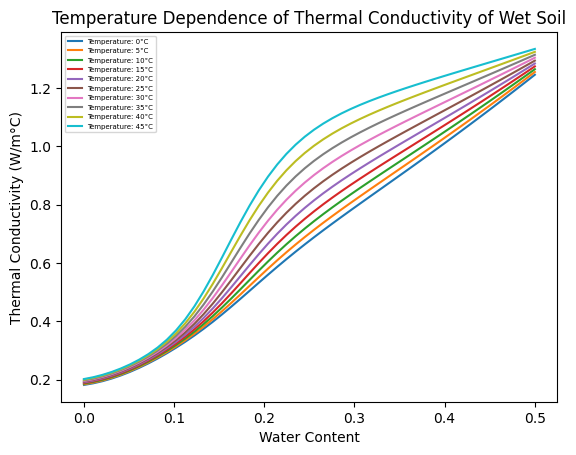

In [18]:
# Define parameters
bulkDensity = 1300  # kg/m^3
clay = 0.4  # Assume clay content of soil
waterContents = np.linspace(0, 0.5, 50)  # Vary water content from 0 to 50%
temperatures = range(0, 50, 5)  # Temperature range from 0°C to 50°C

# Calculate thermal conductivity for each temperature and water content
thermal_conductivities = []
for temp in temperatures:
    conductivity_at_temp = []
    for water_content in waterContents:
        conductivity_at_temp.append(thermalConductivity(bulkDensity, water_content, clay, temp))
    thermal_conductivities.append(conductivity_at_temp)

# Plotting
for i, temp in enumerate(temperatures):
    plt.plot(waterContents, thermal_conductivities[i], label=f'Temperature: {temp}°C')

plt.xlabel('Water Content')
plt.ylabel('Thermal Conductivity (W/m°C)')
plt.title('Temperature Dependence of Thermal Conductivity of Wet Soil')
plt.legend(fontsize='5')
plt.grid(False)
plt.show()